In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

## 1 The Dataset

My model is going to be a multi-class classification problem with 4 classes representing different food types:
    -  Meat
    -  Fish & Seafood
    -  Fruits
    -  Vegetables

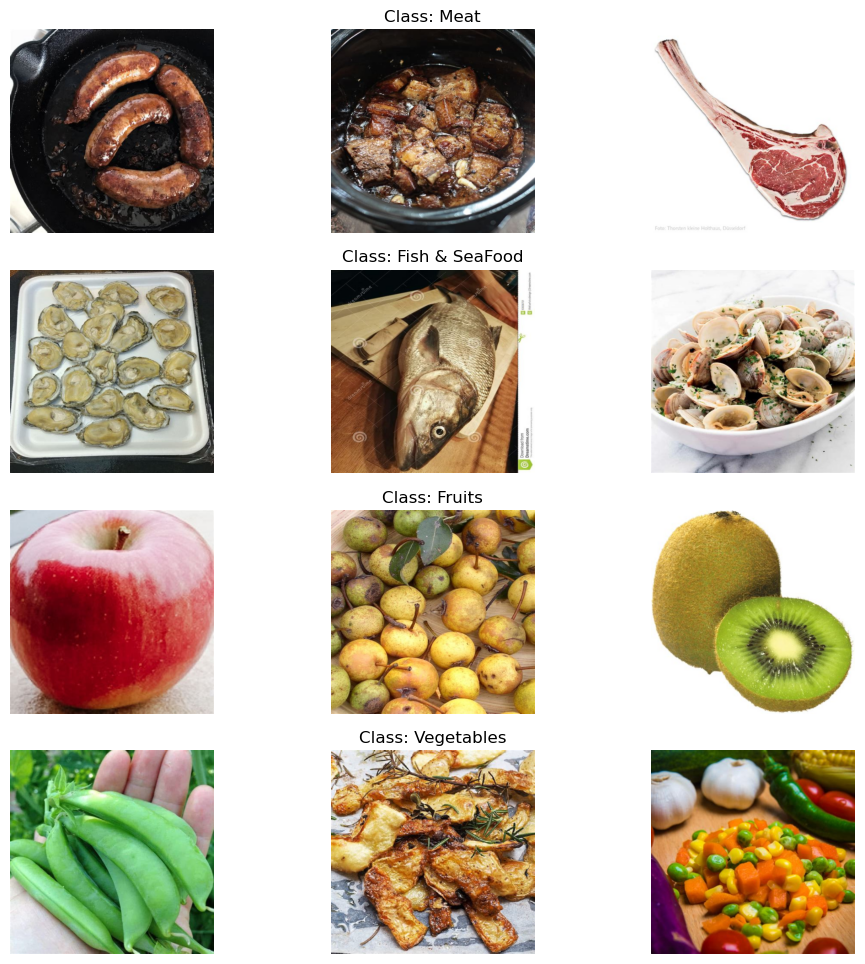

In [2]:
import glob
import cv2

meat, fish, fruits, vegs = 0, 0, 0, 0

fig, ax = plt.subplots(4,3,
                       sharex = 'col',
                       sharey = 'row')

fig.tight_layout(pad=0.25)

fig.set_figheight(10)
fig.set_figwidth(10)

for fpath in glob.glob('/Users/fedor/Desktop/dataset_for_model/4cats_images_DA_copy/*.jpg'):

    im = cv2.imread(fpath, 1)

    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)



    ax[0,1].set_title('Class: Meat', fontsize = 12)
    ax[1,1].set_title('Class: Fish & SeaFood', fontsize = 12)
    ax[2,1].set_title('Class: Fruits', fontsize = 12)
    ax[3,1].set_title('Class: Vegetables', fontsize = 12)

    if 'meat' in fpath:

        if meat < 3:
            ax[0,meat].imshow(cv2.resize(im,(512,512)))
            ax[0,meat].axis('off')

        meat += 1

    elif 'fish' in fpath:

        if fish < 3:
            ax[1,fish].imshow(cv2.resize(im,(512,512)))
            ax[1,fish].axis('off')

        fish += 1

    elif 'fruits' in fpath:

        if  fruits < 3:
            ax[2,fruits].imshow(cv2.resize(im,(512,512)))
            ax[2,fruits].axis('off')

        fruits += 1

    elif 'vegetables' in fpath and vegs < 3:
        if  vegs < 3:
            ax[3,vegs].imshow(cv2.resize(im,(512,512)))
            ax[3,vegs].axis('off')

        vegs += 1

- Each class has 184 images. I decided to go with such a relatively small amount of images as it is better to get high-quality data and augment it later than have a lot of garbage data that will result in garbage output. It makes it 736 images in total. I got these images by using imsitu data set and scrapping the Internet with the help of [DuckDuckGo Image Scrapper](https://github.com/joedockrill/image-scraper).
    - [Imsitu Scrapping Notebook](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-FedorChursin220904/blob/main/Deliverables/scraping_images_imitsu.ipynb)
    - [DuckDuckGo Scrapping Notebook](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-FedorChursin220904/blob/main/Deliverables/ImageScraper_duckduckgo.ipynb)
- Each image is labelled accordingly to the class name in the file name.
- I will split my data accordingly 80% - training set, 10% - test set, and 10% - validation set.
- Each image will be reshaped in 128 x 128 pixels for better performance and faster training.

## 2 Baselines

### Random Guess Accuracy

As I have 4 different classes random guesses will result in around 25% accuracy

### Human-Level Performance Accuracy:

I have made a google form consisting of 10 images. The average HLP accuracy is 90% with a lowest accuracy of 80% and a highest of 100%.

You can find the metrics of the HLP form in the attached image.

[HLP results](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-FedorChursin220904/blob/main/Deliverables/hlp.png)


### Multilayer Perceptron Accuracy:

The accuracy of the MLP model varied between 55% and 62%. In general, models were 35% more accurate than a random guess and 30% less accurate than HLP.

MLP models can be found here:
    - [MLP Model](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-FedorChursin220904/blob/main/Deliverables/W2-DL1-MLP-Student-Notebook.ipynb)
    - [MLP Model with batch size and learning rate tuning, and learning curves visualisations](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-FedorChursin220904/blob/main/Deliverables/W2-DL2-MLP-Student-Notebook.ipynb)

## 3 Data Preprocessing

In the next few steps, I am going to preprocess all the data I have. I will have to complete 6 steps:
   1. Load the data
   2. Change the colour scheme of the data as the open-cv library loads images in the BGR colour scheme instead of RGB
   3. Resize images to 128 x 128 to increase the model performance and decrease the needed computing power
   4. Augment each image to increase the data set size by 10 times. To augment all the data I will apply such transformations as width/height shift, rotation, and horizontal/vertical flip. From each image, I will get 9 new different copies. Image augmentation will help me increase the performance of the model without scrapping new images
   5. Load images into numpy arrays and label them
   6. Split the data set into train, test, and validation sets

In [3]:
from PIL import Image

def preprocess_image(fpath):

    im = cv2.imread(fpath, 1)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    im = cv2.resize(im, (128, 128))

    return  im

In [4]:
data_augmnetation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.45),
    layers.RandomTranslation(
        height_factor = (-0.2,0.2),
        width_factor = (-0.2,0.2),
        fill_mode='reflect',
        interpolation='nearest'
    )
])

def augment_image(image):

    with tf.device('/cpu:0'):

        return  data_augmnetation(image)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [5]:
import glob


X_train = []

data = {
    'meat': [0] * 7360,
    'fish': [0] * 7360,
    'vegetables': [0] * 7360,
    'fruits': [0] * 7360
}

y_train = pd.DataFrame(data)

current_row = 0

for fpath in glob.glob('/Users/fedor/Desktop/dataset_for_model/4cats_images_DA_copy/*.jpg'):

    im = preprocess_image(fpath)

    if 'meat' in fpath:
        for i in range(10):

            augmented_image = augment_image(im)

            y_train.loc[current_row, 'meat'] = 1
            X_train.append(augmented_image)
            current_row += 1


    elif 'fish' in fpath:
        for i in range(10):

            augmented_image = augment_image(im)

            y_train.loc[current_row, 'fish'] = 1
            X_train.append(augmented_image)
            current_row += 1


    elif 'vegetables' in fpath:
        for i in range(10):

            augmented_image = augment_image(im)

            y_train.loc[current_row, 'vegetables'] = 1
            X_train.append(augmented_image)
            current_row += 1

    elif 'fruits' in fpath:
        for i in range(10):

            augmented_image = augment_image(im)

            y_train.loc[current_row, 'fruits'] = 1
            X_train.append(augmented_image)
            current_row += 1

# Convert the list of arrays
# Into a numpy array
X_train = np.array(X_train)

In [6]:
X_train.shape, y_train.shape

((7360, 128, 128, 3), (7360, 4))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,
                                                    test_size = 0.2,
                                                    random_state = 1)

X_validation, X_test, y_validation, y_test = train_test_split(X_test,y_test,
                                                              test_size = 0.5,
                                                              random_state = 1)

### In previous sections I have completed first three steps of The Machine Learning Project Lifecycle - Define project, Define data and Establish baselines, Label and Organise data. In steps 4 - 7 I will cover Modelling part of the Project lifecycle. I will build, train, evaluate, and perform error analysis

## 4 & 5 CNN Architecture & Training

### 5.0.1 Visualisations functions

#### Function to plot loss against val_loss

In [8]:
def loss_plotter(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, '-b', label = 'loss')
    plt.plot(val_loss, '-r', label = 'validation loss')

    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')

    plt.legend(loc='best')


    plt.show()

#### Function to plot accuracy against val_accuracy

In [9]:
def accuracy_plotter(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(accuracy, '-b', label = 'accuracy')
    plt.plot(val_accuracy, '-r', label = 'validation accuracy')

    plt.ylabel('Accuracy')
    plt.xlabel('Number of Epochs')

    plt.legend(loc='best')


    plt.show()

#### Set of functions to decode predictions for visualisations

In [10]:
def decode_predictions(predictions):

    return [['meat','fish','vegetables','fruits'][np.argmax(row)] for row in predictions]

In [11]:
def get_prediction(model, image):

    predict = model.predict(image)

    return [['Meat','Fish','Vegetables','Fruits'][np.argmax(row)] for row in predict][0]

#### Set of functions to appy explainable AI methods to the model

In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [13]:
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return(superimposed_img)

In [14]:
from tf_explain.utils.image import apply_grey_patch


def apply_oculus_sens(img_path,patch_size,class_indx,model):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img = tf.keras.preprocessing.image.img_to_array(img)

    patches = [
        apply_grey_patch(img,top_left_x,top_left_y,patch_size)
        for index_x, top_left_x in enumerate(range(0, img.shape[0], patch_size))
        for index_y, top_left_y in enumerate(range(0, img.shape[1], patch_size))
    ]



    predictions = model.predict(np.array(patches), batch_size = 16);



    target_class_predicitions = [
        prediction[class_indx] for prediction in predictions
    ]

    coordinates = [
        (index_y, index_x)
        for index_x, _ in enumerate(range(0, img.shape[0], patch_size))
        for index_y, _ in enumerate(range(0, img.shape[1], patch_size))
    ]

    sensetivity_map = np.zeros((img.shape[0] // patch_size, img.shape[1] // patch_size))

    for (index_y, index_x), confidience in zip(coordinates, target_class_predicitions):
        # if index_y < 128 and index_x < 128:
        sensetivity_map[index_y,index_x] = 1 - confidience

    return sensetivity_map

In [15]:
import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

def apply_lime_explainer(img,model):
    explainer = lime_image.LimeImageExplainer(verbose = False)
    exp = explainer.explain_instance(img, 
                                 model.predict, 
                                 top_labels=4, 
                                 hide_color=0, 
                                 num_samples=10000)

    return exp

In [16]:
def visualise_lime(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight);
    return mark_boundaries(image, mask);
    

In [17]:
def get_images_for_prediction(model,layer_name, row_n, col_n):
    
    image_col_cnt = 0

    predictions = []

    images_to_plot = []

    for fpath in glob.glob('/Users/fedor/Desktop/dataset_for_model/test_data/*.jpg'):

        if 'meat' in fpath:

            index = 0
        elif 'fish' in fpath:

            index = 1

        elif 'vegetables' in fpath:
             
             index = 2

        else:
            index = 3

        im = preprocess_image(fpath)


        with tf.device('/cpu:0'):
            augmented_image = im

        X_predict = []

        

        X_predict.append(augmented_image)

        X_predict = np.array(X_predict)

        if image_col_cnt < row_n:

            predictions.append(get_prediction(model,X_predict))
            

        preprocess_input = keras.applications.xception.preprocess_input
        decode_predictions = keras.applications.xception.decode_predictions

        img_array = preprocess_input(get_img_array(fpath,(128,128)))
        model.layers[-1].activation = None

        heatmap = make_gradcam_heatmap(img_array,model, layer_name)


    

        if image_col_cnt < row_n:
            
            exp = apply_lime_explainer(preprocess_image(fpath),model)

            images_to_plot.append([cv2.resize(augmented_image,(128,128)),cv2.resize(heatmap,(128,128)),cv2.resize(np.array(save_and_display_gradcam(fpath, heatmap)),(128,128)),np.array(apply_oculus_sens(fpath,patch_size=1,class_indx=index,model = model)),cv2.resize(visualise_lime(exp, exp.top_labels[0], show_positive = True, hide_background = False),(128,128))])

    
        image_col_cnt += 1

    return predictions, images_to_plot

In [18]:
def show_images_for_prediction(images,predictions,row_n, col_n):

    fig, ax = plt.subplots(row_n, col_n,
                           sharex = 'col',
                           sharey = 'row')

    fig.set_figheight(15)
    fig.set_figwidth(10)
    fig.tight_layout(pad=0.45)

    image_col_cnt = 0

    titles = ['Input Image', 'Heatmap', 'Grad_cam Image', 'Oculus Sensitivity Image','Lime Explainer Image']

    

    for index_arr, image_arr in enumerate(images):
        for index_img, image in enumerate(image_arr):
                
                
                
                if index_arr == 0:
                    ax[0,index_img].set_title(titles[index_img])
              

        

                ax[index_arr,index_img].imshow(image)
                if index_img != 0:
                    ax[index_arr,index_img].axis('off')

                ax[index_arr,0].set_xlabel('Predicted Class: ' + predictions[index_arr], fontsize = 12)
                ax[image_col_cnt,0].get_xaxis().set_ticks([])
                ax[image_col_cnt,0].get_yaxis().set_ticks([])

    

        image_col_cnt += 1



### 4.1 & 5.1 CNN Baseline Model Architecture, Training & Visualisations

In [19]:
base_line_model = Sequential()

base_line_model.add(Conv2D(16, (2,2), 1,padding = 'same', activation='relu',input_shape=(128,128,3)))
base_line_model.add(MaxPooling2D())


base_line_model.add(Conv2D(16,(2,2), 1,padding = 'same', activation = 'relu'))
base_line_model.add(MaxPooling2D())



base_line_model.add(Dropout(0.2))

base_line_model.add(Conv2D(16,(1,1), 1,padding = 'same', activation = 'relu'))
base_line_model.add(MaxPooling2D())



base_line_model.add(Conv2D(8,(1,1), 1,padding = 'same', activation = 'relu'))
base_line_model.add(MaxPooling2D())


base_line_model.add(Dropout(0.2))


base_line_model.add(Conv2D(4,(1,1), 1,padding = 'same', activation = 'relu'))
base_line_model.add(MaxPooling2D())



base_line_model.add(Flatten())

base_line_model.add(Dropout(0.2))

base_line_model.add(Dense(32,activation='relu'))


base_line_model.add(Dense(16,activation='relu'))


base_line_model.add(Dense(8,activation='relu'))

base_line_model.add(Dense(4, activation = 'softmax'))

In [20]:
base_line_model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [21]:
base_line_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)       

In [22]:
monitor_val_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

mcp_save = ModelCheckpoint('base_line_model_best_acc.hdf5', save_best_only=True, monitor='val_accuracy')

history_base_model = base_line_model.fit(X_train, y_train,
                    epochs = 150, validation_data = (X_test, y_test), callbacks=[monitor_val_accuracy,mcp_save],verbose = 1)

Epoch 1/150


2023-04-05 20:32:24.881035: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


184/184 [==============================] - 7s 33ms/step - loss: 2.2832 - accuracy: 0.2588 - val_loss: 1.3610 - val_accuracy: 0.2812
Epoch 2/150
184/184 [==============================] - 6s 31ms/step - loss: 1.2966 - accuracy: 0.3495 - val_loss: 1.2256 - val_accuracy: 0.4579
Epoch 3/150
184/184 [==============================] - 6s 31ms/step - loss: 1.1777 - accuracy: 0.4502 - val_loss: 1.1943 - val_accuracy: 0.4076
Epoch 4/150
184/184 [==============================] - 6s 31ms/step - loss: 1.1214 - accuracy: 0.4642 - val_loss: 1.1207 - val_accuracy: 0.5272
Epoch 5/150
184/184 [==============================] - 6s 31ms/step - loss: 1.0631 - accuracy: 0.4864 - val_loss: 1.0635 - val_accuracy: 0.4810
Epoch 6/150
184/184 [==============================] - 6s 31ms/step - loss: 1.0245 - accuracy: 0.5048 - val_loss: 0.9789 - val_accuracy: 0.5394
Epoch 7/150
184/184 [==============================] - 6s 31ms/step - loss: 0.9878 - accuracy: 0.5217 - val_loss: 1.0266 - val_accuracy: 0.4905
Epoc

In [23]:
base_line_model.evaluate(X_validation, y_validation)

23/23 [==============================] - 0s 10ms/step - loss: 0.8476 - accuracy: 0.6399


[0.8475921750068665, 0.6399456858634949]

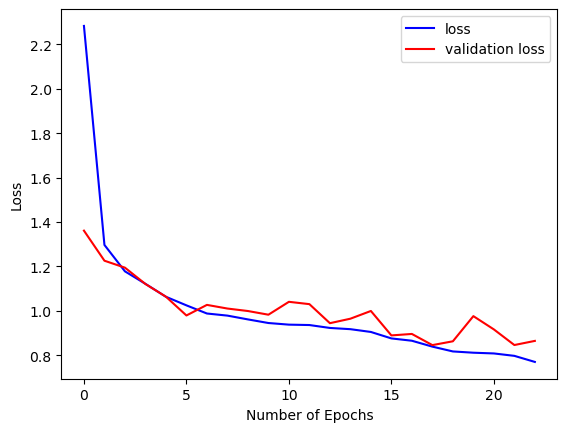

In [24]:
loss_plotter(history_base_model)

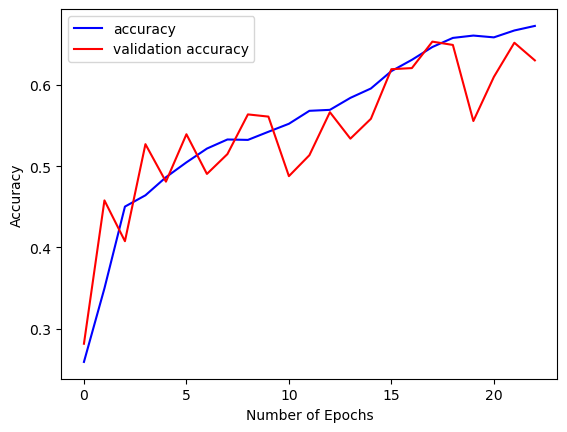

In [25]:
accuracy_plotter(history_base_model)

Due to the high patience of the EarlyStopping callback, we can see that model starts to overfit, nevertheless as the restore_best_weights value is set to true only the best model is saved and used for further evaluation and predictions


### 

### 4.2 & 5.2 CNN Baseline Model Improvement, Training, Optimizers & Visaulisations

In [26]:
tuned_base_line_model = Sequential()

tuned_base_line_model.add(Conv2D(16, (1,1), 1, activation='relu',input_shape=(128,128,3)))
tuned_base_line_model.add(MaxPooling2D())

tuned_base_line_model.add(Conv2D(32,(1,1), 1, activation = 'relu'))
tuned_base_line_model.add(MaxPooling2D())

tuned_base_line_model.add(Conv2D(8,(1,1), 1, activation = 'relu'))
tuned_base_line_model.add(MaxPooling2D())

tuned_base_line_model.add(Flatten())

tuned_base_line_model.add(Dropout(0.2))

tuned_base_line_model.add(Dense(4096, activation='relu'))

tuned_base_line_model.add(Dense(2048, activation='relu'))
tuned_base_line_model.add(Dense(1024,activation='relu'))


tuned_base_line_model.add(Dense(512,activation='relu'))
tuned_base_line_model.add(Dense(256,activation='relu'))
tuned_base_line_model.add(Dense(128,activation='relu'))

tuned_base_line_model.add(Dense(32,activation='relu'))

tuned_base_line_model.add(Dense(4, activation = 'softmax'))

In [27]:


tuned_base_line_model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [28]:
tuned_base_line_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      64        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        544       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 8)         264       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 8)       

In [29]:
monitor_val_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

mcp_save = ModelCheckpoint('tuned_base_line_moedl_best_acc.hdf5', save_best_only=True, monitor='val_accuracy')



history_updated_model = tuned_base_line_model.fit(X_train, y_train,
                          epochs = 150, validation_data = (X_test, y_test), callbacks=[monitor_val_accuracy,mcp_save],verbose = 1)

Epoch 1/150
184/184 [==============================] - 6s 31ms/step - loss: 5.0531 - accuracy: 0.3088 - val_loss: 1.2002 - val_accuracy: 0.4212
Epoch 2/150
184/184 [==============================] - 5s 29ms/step - loss: 1.0936 - accuracy: 0.4762 - val_loss: 0.9152 - val_accuracy: 0.6128
Epoch 3/150
184/184 [==============================] - 5s 28ms/step - loss: 0.9978 - accuracy: 0.5363 - val_loss: 0.8889 - val_accuracy: 0.6182
Epoch 4/150
184/184 [==============================] - 5s 27ms/step - loss: 0.9254 - accuracy: 0.5854 - val_loss: 0.9534 - val_accuracy: 0.5571
Epoch 5/150
184/184 [==============================] - 5s 27ms/step - loss: 0.8860 - accuracy: 0.6053 - val_loss: 0.9019 - val_accuracy: 0.5965
Epoch 6/150
184/184 [==============================] - 5s 28ms/step - loss: 0.8563 - accuracy: 0.6277 - val_loss: 0.7751 - val_accuracy: 0.6726
Epoch 7/150
184/184 [==============================] - 5s 27ms/step - loss: 0.7976 - accuracy: 0.6578 - val_loss: 0.8559 - val_accuracy:

In [30]:
tuned_base_line_model.evaluate(X_validation,y_validation)

23/23 [==============================] - 0s 12ms/step - loss: 1.0723 - accuracy: 0.7052


[1.0722819566726685, 0.7051630616188049]

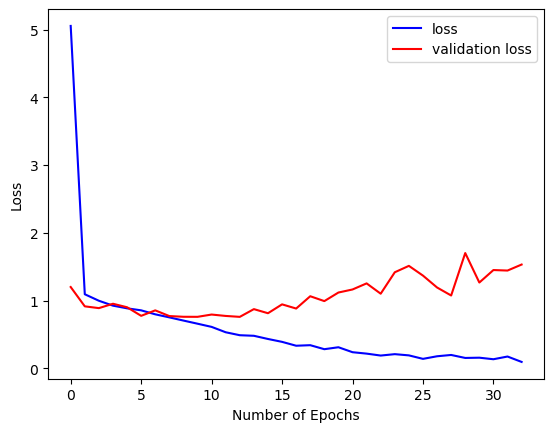

In [31]:
loss_plotter(history_updated_model)

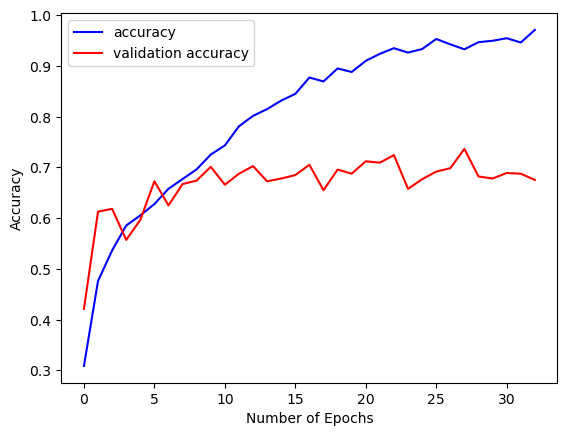

In [32]:
accuracy_plotter(history_updated_model)

Due to the high patience of the EarlyStopping callback, we can see that model starts to overfit, nevertheless as the restore_best_weights value is set to true only the best model is saved and used for further evaluation and predictions


### 4.3 & 5.3 Transfer learning model & Visaulisations

In [33]:
vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (128,128,3))

for layer in vgg16.layers:
    layer.trainable = False

model_vgg16 = Sequential()
model_vgg16.add(vgg16)



model_vgg16.add(Flatten())


model_vgg16.add(Dense(32, activation='relu'))
model_vgg16.add(layers.BatchNormalization(epsilon = 1e-05, momentum = 0.1))



model_vgg16.add(Dense(8, activation='relu'))
model_vgg16.add(layers.BatchNormalization(epsilon = 1e-05, momentum = 0.1))


model_vgg16.add(Dense(4, activation='softmax'))



In [34]:
model_vgg16.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [35]:
monitor_val_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
mcp_save = ModelCheckpoint('transfer_learning_model_best_accuracy.hdf5', save_best_only=True, monitor='val_accuracy')

with tf.device('/gpu:0'):
    history_transfer_learning_model = model_vgg16.fit(X_train, y_train,
                        epochs = 150, validation_data = (X_test, y_test), callbacks=[monitor_val_accuracy,mcp_save], verbose = 1)

Epoch 1/150
184/184 [==============================] - 21s 108ms/step - loss: 0.9106 - accuracy: 0.6374 - val_loss: 0.6592 - val_accuracy: 0.7446
Epoch 2/150
184/184 [==============================] - 19s 106ms/step - loss: 0.4492 - accuracy: 0.8558 - val_loss: 0.5978 - val_accuracy: 0.7649
Epoch 3/150
184/184 [==============================] - 19s 104ms/step - loss: 0.2316 - accuracy: 0.9404 - val_loss: 2.0796 - val_accuracy: 0.7948
Epoch 4/150
184/184 [==============================] - 19s 105ms/step - loss: 0.1296 - accuracy: 0.9740 - val_loss: 0.6675 - val_accuracy: 0.7976
Epoch 5/150
184/184 [==============================] - 19s 104ms/step - loss: 0.0835 - accuracy: 0.9827 - val_loss: 1.2849 - val_accuracy: 0.8030
Epoch 6/150
184/184 [==============================] - 19s 106ms/step - loss: 0.0627 - accuracy: 0.9859 - val_loss: 0.5844 - val_accuracy: 0.8179
Epoch 7/150
184/184 [==============================] - 19s 102ms/step - loss: 0.0475 - accuracy: 0.9893 - val_loss: 10.0249 

In [36]:
model_vgg16.evaluate(X_validation,y_validation)

23/23 [==============================] - 2s 88ms/step - loss: 0.6274 - accuracy: 0.7908


[0.6274213194847107, 0.79076087474823]

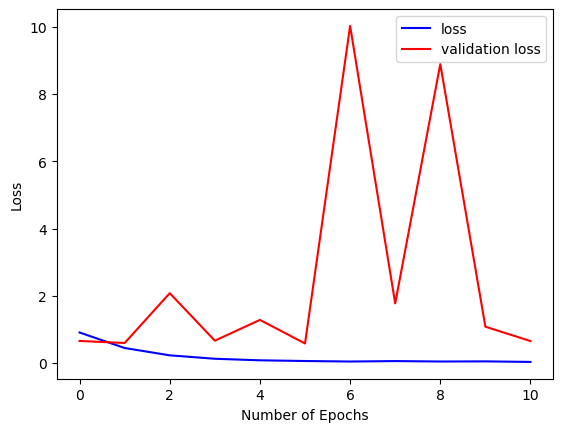

In [37]:
loss_plotter(history_transfer_learning_model)

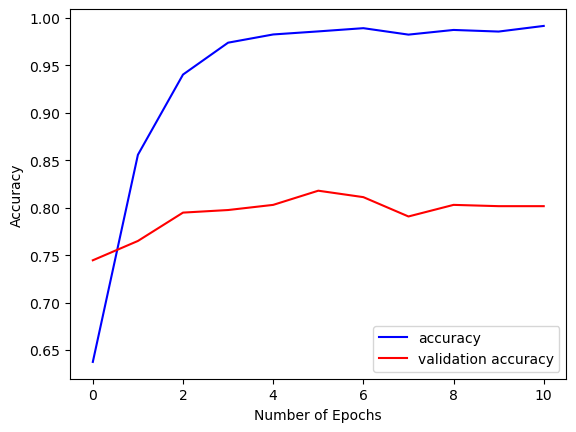

In [38]:
accuracy_plotter(history_transfer_learning_model)

Due to the high patience of the EarlyStopping callback, we can see that model starts to overfit, nevertheless as the restore_best_weights value is set to true only the best model is saved and used for further evaluation and predictions


## 5.3 Applying AI explainable methods to base line and tuned base line model

### Base line model

In [39]:
%%capture test
preds, images = get_images_for_prediction(base_line_model,'conv2d_2',5,5) 

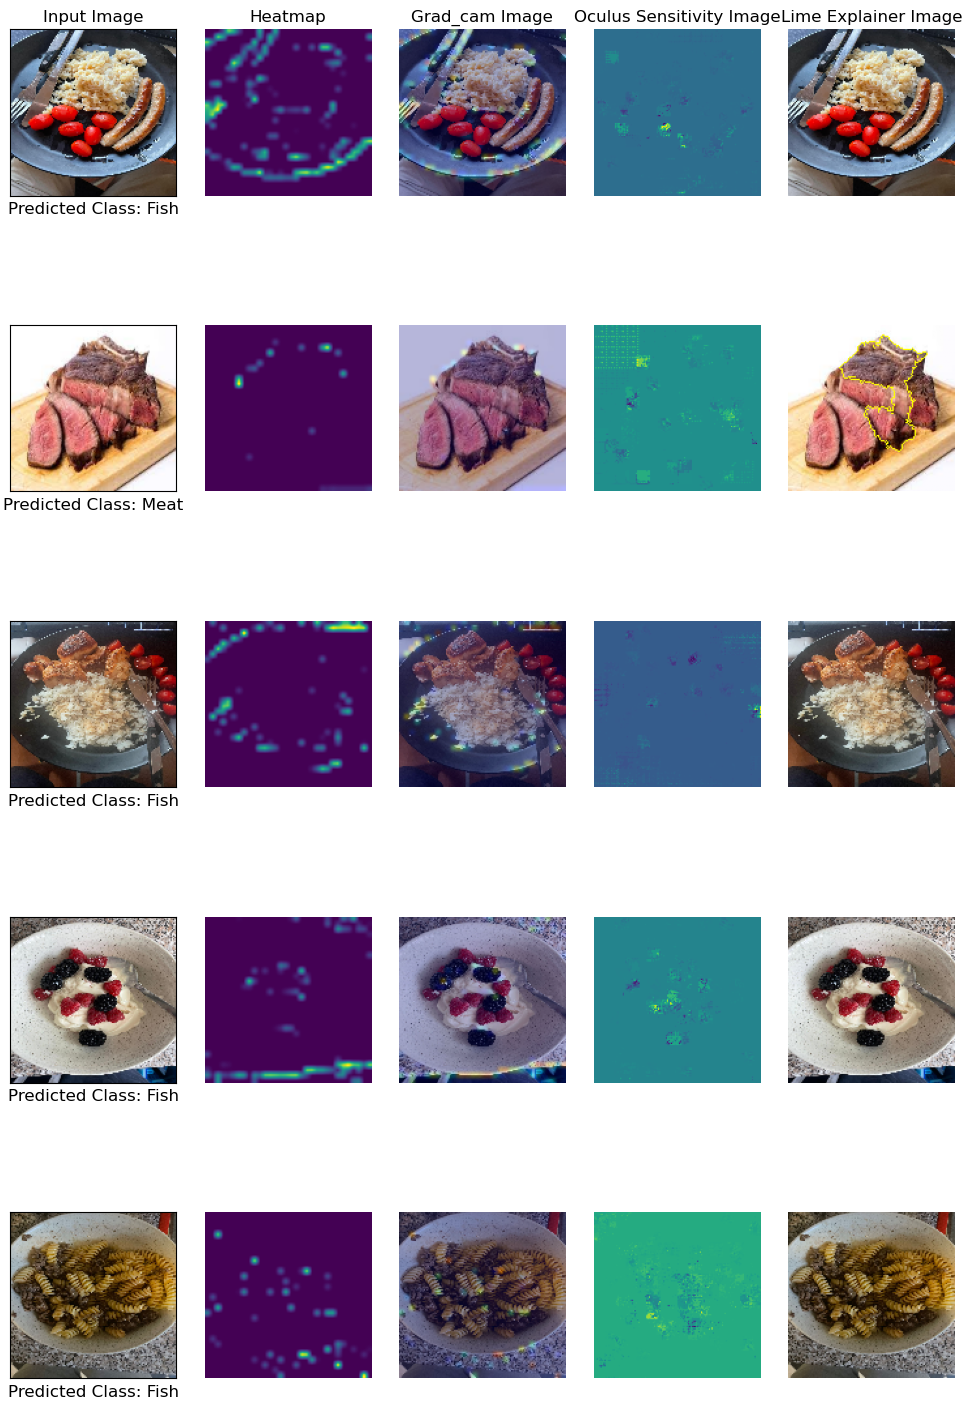

In [40]:
show_images_for_prediction(images,preds,5,5)

### Tuned base line model

In [41]:
%%capture test
preds_tuned_model, images_tuned_model = get_images_for_prediction(tuned_base_line_model,'conv2d_7',5,5) 

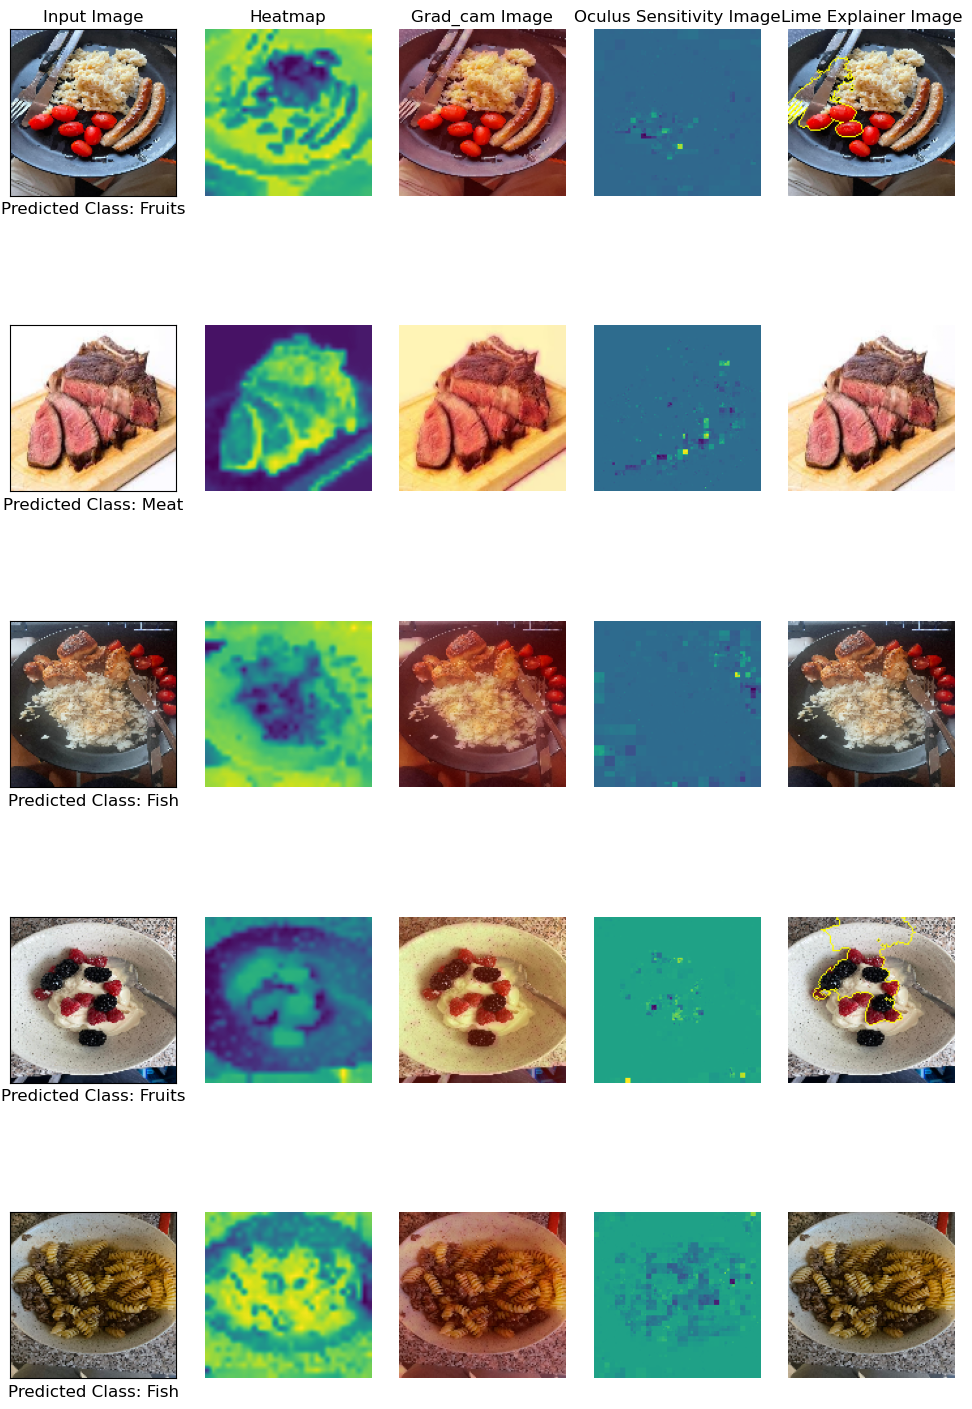

In [42]:
show_images_for_prediction(images_tuned_model,preds_tuned_model,5,5)

## 6 Models performance

#### Set of functions to assess performance of the model

In [43]:
def decode_targets(y_target):

    y_target = y_target.reset_index()

    y_decoded = [''] * 736

    meat_index = y_target.index[y_target['meat'] == 1].tolist()

    fish_index = y_target.index[y_target['fish'] == 1].tolist()

    fruits_index = y_target.index[y_target['fruits'] == 1].tolist()

    vegetables_index = y_target.index[y_target['vegetables'] == 1].tolist()

    for index in meat_index:

        y_decoded[index] = 'meat'

    for index in fish_index:

        y_decoded[index] = 'fish'

    for index in fruits_index:

        y_decoded[index] = 'fruits'

    for index in vegetables_index:

        y_decoded[index] = 'vegetables'

    return y_decoded

In [44]:
from sklearn.metrics import classification_report


def show_metrics_for_model(model):

    y_val_for_metrics = decode_targets(y_validation)

    y_predictions = decode_predictions(model.predict(X_validation, batch_size=64, verbose=1))

    return(classification_report(y_val_for_metrics, y_predictions))

In [45]:
from sklearn import metrics

def show_cm_for_model(model):

    y_val_for_metrics = decode_targets(y_validation)

    y_predictions = decode_predictions(model.predict(X_validation, batch_size=64, verbose=1))

    confusion_matrix = metrics.confusion_matrix(y_val_for_metrics,y_predictions)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['Fish','Fruits','Meat','Vegetables'])

    cm_display.plot()
    plt.show()

### 6.1 Performance metrics of the baseline model

In [46]:
print(show_metrics_for_model(base_line_model))

12/12 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

        fish       0.49      0.79      0.60       182
      fruits       0.78      0.63      0.70       202
        meat       0.74      0.67      0.71       165
  vegetables       0.70      0.47      0.56       187

    accuracy                           0.64       736
   macro avg       0.68      0.64      0.64       736
weighted avg       0.68      0.64      0.64       736



12/12 [==============================] - 0s 7ms/step


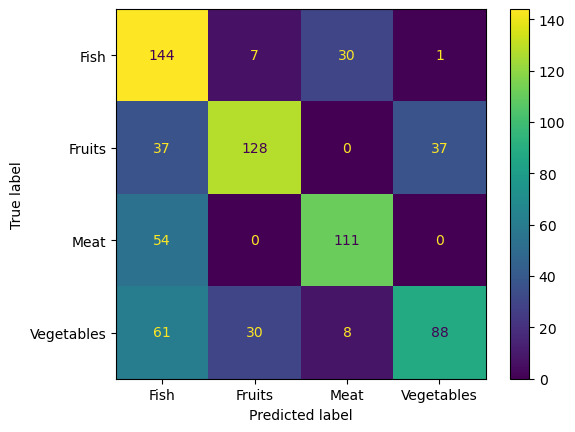

In [47]:
show_cm_for_model(base_line_model)

### 6.2 Performance metrics of the improved baseline model

In [48]:
print(show_metrics_for_model(tuned_base_line_model))

12/12 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

        fish       0.64      0.62      0.63       182
      fruits       0.77      0.78      0.78       202
        meat       0.73      0.76      0.74       165
  vegetables       0.67      0.66      0.67       187

    accuracy                           0.71       736
   macro avg       0.70      0.70      0.70       736
weighted avg       0.70      0.71      0.70       736



12/12 [==============================] - 0s 12ms/step


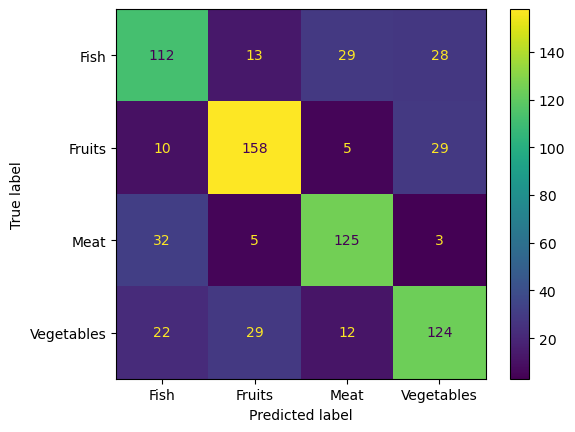

In [49]:
show_cm_for_model(tuned_base_line_model)

### 6.3 Performance metrics of the model with transfer learning

In [50]:
print(show_metrics_for_model(model_vgg16))

12/12 [==============================] - 2s 168ms/step
              precision    recall  f1-score   support

        fish       0.76      0.67      0.71       182
      fruits       0.88      0.90      0.89       202
        meat       0.71      0.80      0.75       165
  vegetables       0.80      0.78      0.79       187

    accuracy                           0.79       736
   macro avg       0.79      0.79      0.79       736
weighted avg       0.79      0.79      0.79       736



12/12 [==============================] - 2s 167ms/step


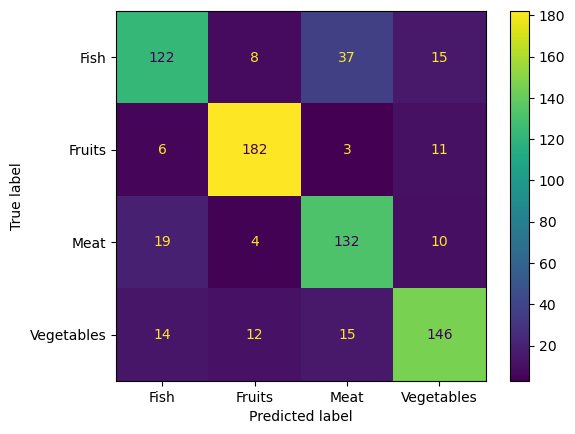

In [51]:
show_cm_for_model(model_vgg16)

By looking at metrics and confusion matrix for each model we can see that performance of the model improves indeed. After three iterations I have 3 different models: 
1. Base Line model with the poorest performance 
2. Tuned Base Line model with the mid-performance 
3. Transfer-learning model with the best performance

## 7 Error analysis

In [52]:
def get_most_missclassified_class(model):

    targets = decode_targets(y_validation)

    predictions = decode_predictions(model.predict(X_validation, verbose = 0))

    miss_counter_per_class = [0,0,0,0]

    for index, prediction in enumerate(predictions):
        if prediction != targets[index]:
            
            if targets[index] == 'meat':
                miss_counter_per_class[0] += 1
            elif targets[index] == 'fish':
                miss_counter_per_class[1] += 1
            elif targets[index] == 'vegetables':
                miss_counter_per_class[2] += 1
            else:
                miss_counter_per_class[3] += 1
    

    list_for_df = {
        'Meat': [miss_counter_per_class[0]],
        'Fish': [miss_counter_per_class[1]],
        'Vegetables': [miss_counter_per_class[2]],
        'Fruits': [miss_counter_per_class[3]]
    }

    return pd.DataFrame(list_for_df)

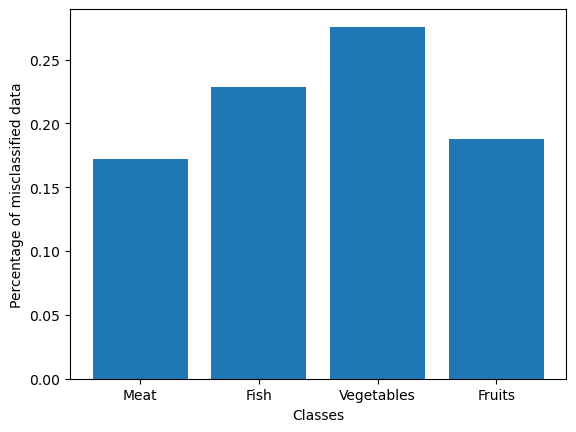

In [53]:
data_for_visualisations = get_most_missclassified_class(base_line_model) + get_most_missclassified_class(tuned_base_line_model) + get_most_missclassified_class(model_vgg16)
plt.bar(data_for_visualisations.columns,data_for_visualisations.values[0]/736)
plt.ylabel('Percentage of misclassified data')
plt.xlabel('Classes')
plt.show()

From the plots above it's clear that two mostly missclassified classes are Fish and Vegetables. Because of that I want to take a deeper look at missclassified images from these classes to find the cause of such occasion.

In [54]:
import random


def show_images_for_wrong_prediction(model,layer_name, row_n, col_n):

        fig, ax = plt.subplots(row_n, col_n,
                               sharex = 'col',
                               sharey = 'row')

        fig.set_figheight(15)
        fig.set_figwidth(10)
        fig.tight_layout(pad=0.45)

        image_col_cnt = 0

        fish_ex_num = 0
        vegs_ex_num = 0

        for fpath in glob.glob('/Users/fedor/Desktop/dataset_for_model/each_cat_750_f/*.jpg'):

            to_plot = False

            im = preprocess_image(fpath)

            if image_col_cnt >= row_n:
                break

            with tf.device('/cpu:0'):
                augmented_image = im

            X_predict = []

            X_predict.append(augmented_image)

            X_predict = np.array(X_predict)

            prediction = get_prediction(model,X_predict)



            if 'fish' in fpath and prediction != 'Fish' and fish_ex_num < row_n / 2 :
                to_plot = True

            elif 'vegetables' in fpath and prediction != 'Vegetables' and vegs_ex_num < row_n / 2:

                to_plot = True

            if random.randint(0,100) > 25:

                to_plot = False

            if to_plot:

                if 'fish' in fpath:

                    fish_ex_num += 1

                elif ' vegetables' in fpath:

                    vegs_ex_num += 1

                if image_col_cnt < row_n:

                    if image_col_cnt == 0:
                        ax[image_col_cnt,0].set_title('Input Image')

                    ax[image_col_cnt,0].imshow(cv2.resize(augmented_image,(128,128)))
                    ax[image_col_cnt,0].set_xlabel('Predicted Class: ' + prediction, fontsize = 12)
                    ax[image_col_cnt,0].get_xaxis().set_ticks([])
                    ax[image_col_cnt,0].get_yaxis().set_ticks([])



                preprocess_input = keras.applications.xception.preprocess_input
                decode_predictions = keras.applications.xception.decode_predictions

                img_array = preprocess_input(get_img_array(fpath,(128,128)))
                model.layers[-1].activation = None

                heatmap = make_gradcam_heatmap(img_array,model, layer_name)


                if image_col_cnt < row_n:

                    if image_col_cnt == 0:
                        ax[image_col_cnt,1].set_title('Heatmap')

                    ax[image_col_cnt,1].imshow(cv2.resize(heatmap,(128,128)))
                    ax[image_col_cnt,1].axis('off')



                if image_col_cnt < row_n:

                    if image_col_cnt == 0:
                        ax[image_col_cnt,2].set_title('Gradcam Image')

                    ax[image_col_cnt,2].imshow(cv2.resize(np.array(save_and_display_gradcam(fpath, heatmap)),(128,128)))
                    ax[image_col_cnt,2].axis('off')

                image_col_cnt += 1

1/1 [==============================] - 0s 13ms/step


/var/folders/7x/pkl50ghj76g8t2s0y2s5bcrw0000gn/T/ipykernel_83892/1738666412.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 12ms/step


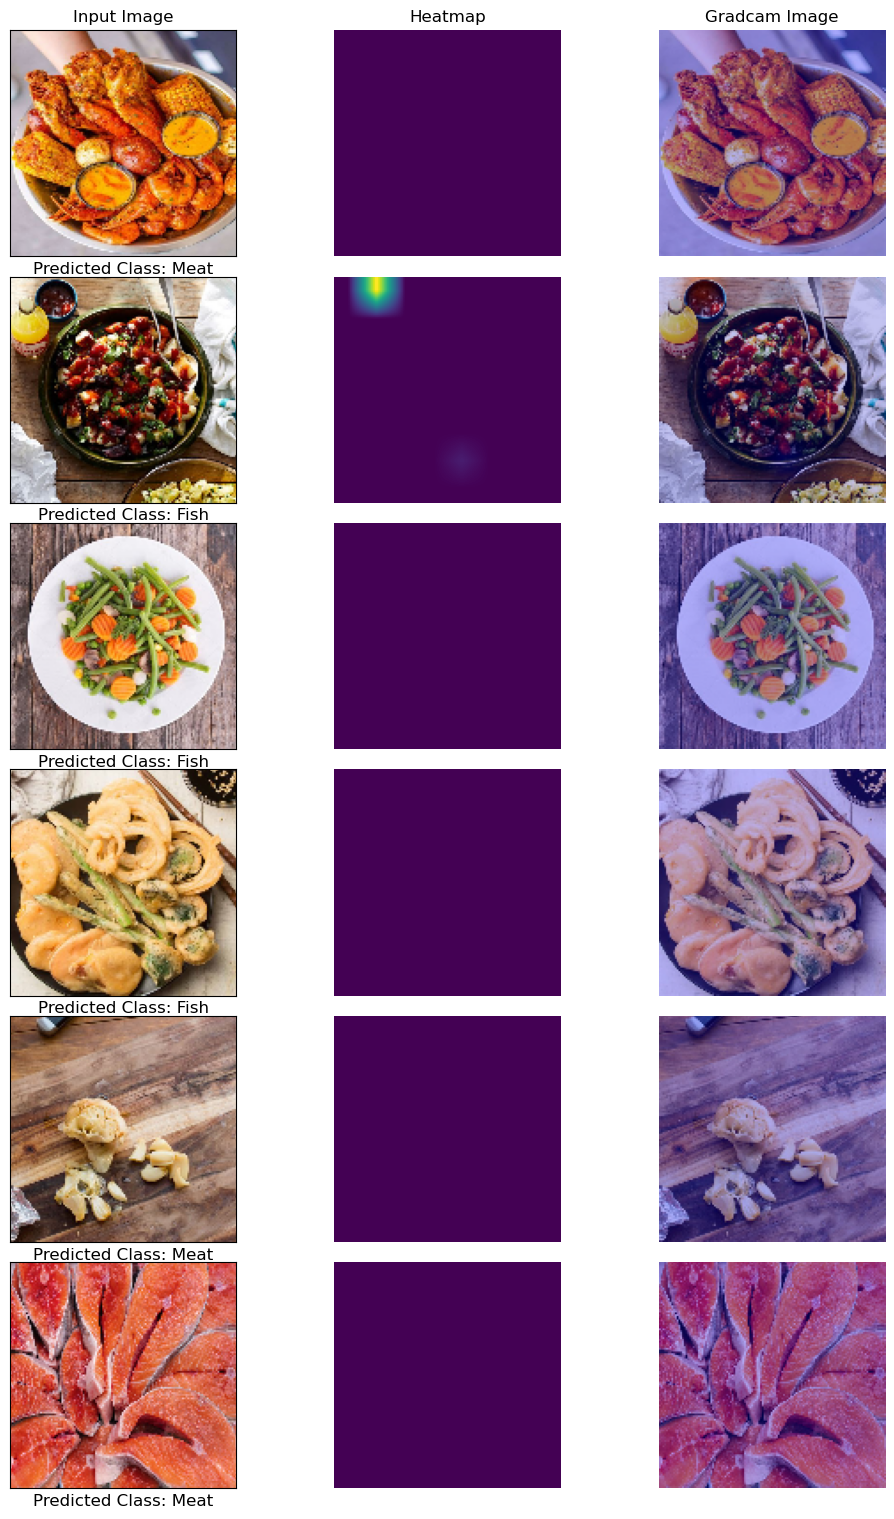

In [55]:
show_images_for_wrong_prediction(base_line_model,'conv2d_4',6,3)

1/1 [==============================] - 0s 34ms/step


/var/folders/7x/pkl50ghj76g8t2s0y2s5bcrw0000gn/T/ipykernel_83892/1738666412.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 27ms/step


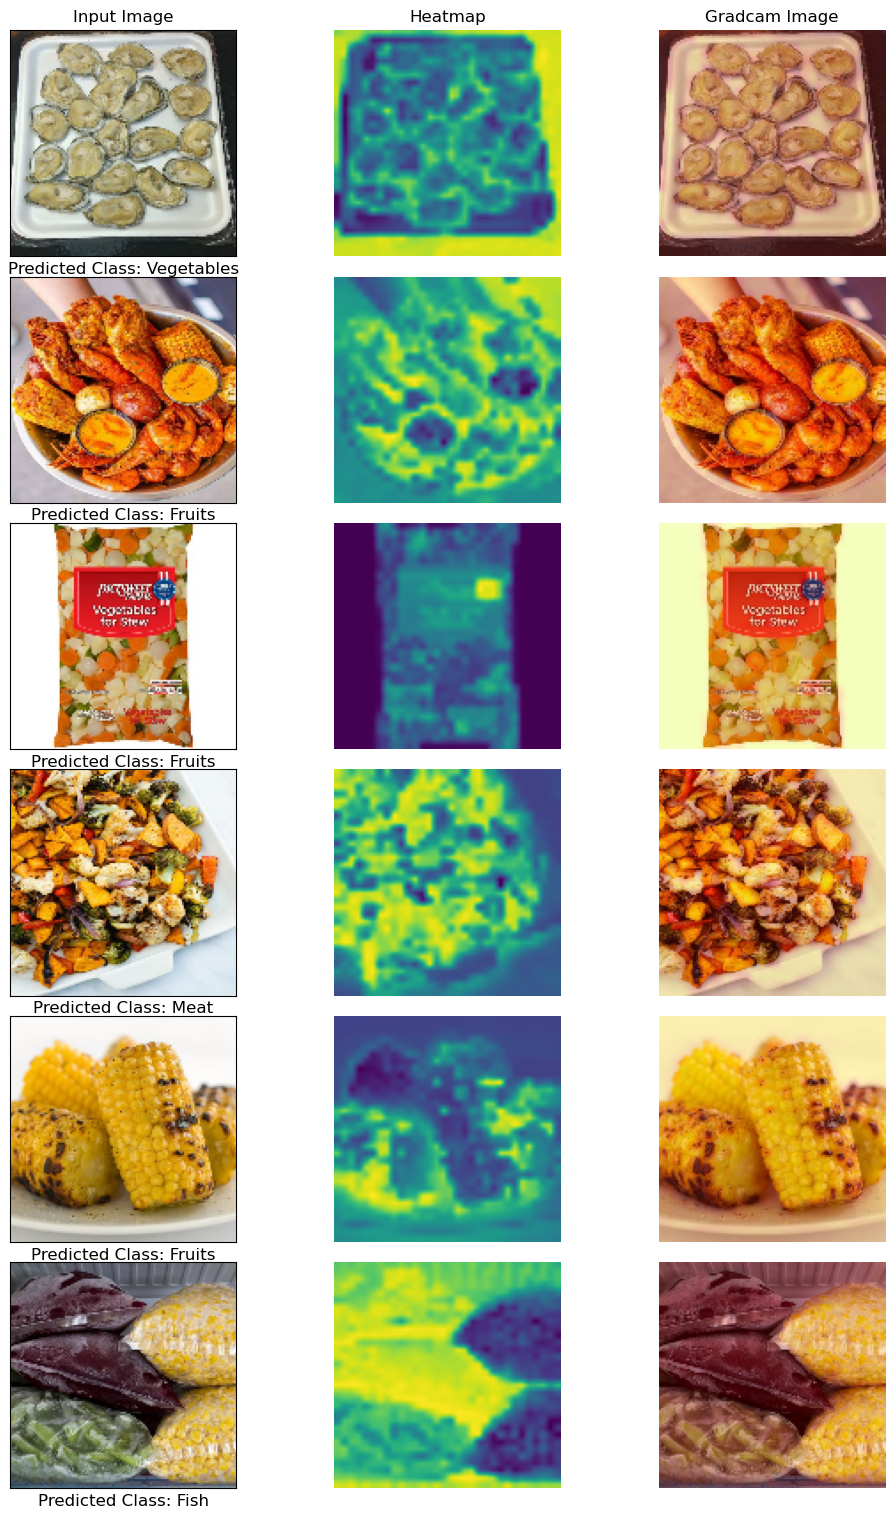

In [56]:
show_images_for_wrong_prediction(tuned_base_line_model,'conv2d_7',6,3)

After looking at the wrong predictions I want to point out a few things:
    1. Model is affected by the lack of variety of quality data. To improve the performance of the model I should scrape more images of food in different representations.
    2. To improve the performance of the model I should implement object detection as pictures of different meals can consist of several classes. Object detection will help to assign several labels to one image.
    3. Because of a relatively small amount of data, the model starts to recognise patterns which leads to overfitting.

### After completing all these steps model is ready for the last part of The Machine Learning Project Lifecycle - Deployment